In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [2]:
import pandas as pd
import torch
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
from transformers import BertModel
import torch.nn as nn
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import multiprocessing

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())  # Should print True if CUDA is detected
print(torch.cuda.device_count())  # Should return the number of GPUs available
print(torch.cuda.get_device_name(0))  # Should print the name of the GPU (e.g., NVIDIA GeForce RTX 4060)


True
1
NVIDIA GeForce RTX 4060 Laptop GPU


In [3]:
# Load your dataset
data = pd.read_csv("Modified_Data.csv")

# Split into train and validation sets
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

c:\Users\ashvi\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [4]:
# Tokenize data
def tokenize_data(data):
    return tokenizer(
        data["crimeaditionalinfo"].tolist(),
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )

# Tokenize both train and validation data
train_encodings = tokenize_data(train_data)
val_encodings = tokenize_data(val_data)


In [5]:
# Convert labels to tensors
train_labels_category = torch.tensor(train_data["category"].values)
train_labels_sub_category = torch.tensor(train_data["sub_category"].values)

val_labels_category = torch.tensor(val_data["category"].values)
val_labels_sub_category = torch.tensor(val_data["sub_category"].values)

In [6]:
# Convert labels to long data type
train_labels_category = train_labels_category.long()
train_labels_sub_category = train_labels_sub_category.long()

val_labels_category = val_labels_category.long()
val_labels_sub_category = val_labels_sub_category.long()

In [7]:
#For gradient accumulation 
accumulation_steps = 8
batch_size = 8

#Optimizations for memory
num_workers = min(20, multiprocessing.cpu_count())  # Number of CPU workers for data loading
use_mixed_precision = True  # Toggle mixed precision as needed
print(num_workers)

20


In [8]:
# Create datasets and data loaders
train_dataset = TensorDataset(
    train_encodings['input_ids'], train_encodings['attention_mask'],
    train_labels_category, train_labels_sub_category
)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Similar setup for the validation loader
val_dataset = TensorDataset(
    val_encodings['input_ids'], val_encodings['attention_mask'],
    val_labels_category, val_labels_sub_category
)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


In [9]:
class MultiTaskModel(nn.Module):
    def __init__(self, model_name, num_labels_task1, num_labels_task2):
        super(MultiTaskModel, self).__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.classifier_task1 = nn.Linear(self.bert.config.hidden_size, num_labels_task1)
        self.classifier_task2 = nn.Linear(self.bert.config.hidden_size, num_labels_task2)

    def forward(self, input_ids, attention_mask, labels_task1=None, labels_task2=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        logits_task1 = self.classifier_task1(pooled_output)
        logits_task2 = self.classifier_task2(pooled_output)

        loss = None
        if labels_task1 is not None and labels_task2 is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss_task1 = loss_fn(logits_task1, labels_task1)
            loss_task2 = loss_fn(logits_task2, labels_task2)
            loss = loss_task1 + loss_task2

        return {"loss": loss, "logits_task1": logits_task1, "logits_task2": logits_task2}

In [10]:
num_labels_task1 = 15
num_labels_task2 = 35

print(f"Unique classes in 'category': {num_labels_task1}")
print(f"Unique classes in 'sub_category': {num_labels_task2}")

# Initialize the model with dynamic class counts
model = MultiTaskModel("bert-base-uncased", num_labels_task1=num_labels_task1, num_labels_task2=num_labels_task2)
model.to(device)

Unique classes in 'category': 15
Unique classes in 'sub_category': 35


MultiTaskModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [11]:
# Assume `train_labels_category` is a tensor of class labels
class_counts = torch.bincount(train_labels_category)
class_weights = 1.0 / class_counts  # Inverse of class frequencies
sample_weights = class_weights[train_labels_category]

# Use WeightedRandomSampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# Create the DataLoader with sampler
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'],
                              train_labels_category, train_labels_sub_category)
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)


In [12]:
optimizer = optim.AdamW(model.parameters(), lr=2e-5)

In [13]:
# Initialize lists to store metrics
train_accuracies_task1 = []
train_accuracies_task2 = []
val_accuracies_task1 = []
val_accuracies_task2 = []

In [14]:
scaler = GradScaler() if use_mixed_precision else None

C:\Users\ashvi\AppData\Local\Temp\ipykernel_28460\677476163.py:1: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if use_mixed_precision else None


In [15]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

In [16]:
for epoch in range(10):
    model.train()
    total_train_loss = 0
    train_preds_task1, train_preds_task2 = [], []
    train_labels_task1, train_labels_task2 = [], []

    for step, batch in enumerate(train_loader):
        # Move batch data to the device with non_blocking for faster transfer
        input_ids = batch[0].to(device, non_blocking=True)
        attention_mask = batch[1].to(device, non_blocking=True)
        labels_task1 = batch[2].to(device, non_blocking=True)
        labels_task2 = batch[3].to(device, non_blocking=True)

        # Forward pass with mixed precision if enabled
        if use_mixed_precision:
            with autocast():
                outputs = model(input_ids=input_ids, attention_mask=attention_mask,
                                labels_task1=labels_task1, labels_task2=labels_task2)
                loss = outputs["loss"] / accumulation_steps
        else:
            outputs = model(input_ids=input_ids, attention_mask=attention_mask,
                            labels_task1=labels_task1, labels_task2=labels_task2)
            loss = outputs["loss"] / accumulation_steps

        total_train_loss += loss.item() * accumulation_steps

        # Backward pass with scaling if mixed precision is enabled
        if use_mixed_precision:
            scaler.scale(loss).backward()
        else:
            loss.backward()

        # Gradient accumulation step
        if (step + 1) % accumulation_steps == 0:
            if use_mixed_precision:
                scaler.step(optimizer)
                scaler.update()
            else:
                optimizer.step()
            optimizer.zero_grad()

        # Move predictions and labels to CPU for accuracy calculation
        train_preds_task1.extend(torch.argmax(outputs["logits_task1"], axis=1).detach().cpu().numpy())
        train_preds_task2.extend(torch.argmax(outputs["logits_task2"], axis=1).detach().cpu().numpy())
        train_labels_task1.extend(labels_task1.detach().cpu().numpy())
        train_labels_task2.extend(labels_task2.detach().cpu().numpy())

    # Calculate training accuracy once per epoch
    train_accuracy_task1 = accuracy_score(train_labels_task1, train_preds_task1)
    train_accuracy_task2 = accuracy_score(train_labels_task2, train_preds_task2)
    train_accuracies_task1.append(train_accuracy_task1)
    train_accuracies_task2.append(train_accuracy_task2)

    # Validation phase
    model.eval()
    val_preds_task1, val_preds_task2 = [], []
    val_labels_task1, val_labels_task2 = [], []
    
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch[0].to(device, non_blocking=True)
            attention_mask = batch[1].to(device, non_blocking=True)
            labels_task1 = batch[2].to(device, non_blocking=True)
            labels_task2 = batch[3].to(device, non_blocking=True)

            # Mixed precision forward pass if enabled
            if use_mixed_precision:
                with autocast():
                    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            else:
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            # Move predictions and labels back to CPU for accuracy calculation
            val_preds_task1.extend(torch.argmax(outputs["logits_task1"], axis=1).cpu().numpy())
            val_preds_task2.extend(torch.argmax(outputs["logits_task2"], axis=1).cpu().numpy())
            val_labels_task1.extend(labels_task1.cpu().numpy())
            val_labels_task2.extend(labels_task2.cpu().numpy())

    # Calculate validation accuracy once per epoch
    val_accuracy_task1 = accuracy_score(val_labels_task1, val_preds_task1)
    val_accuracy_task2 = accuracy_score(val_labels_task2, val_preds_task2)
    val_accuracies_task1.append(val_accuracy_task1)
    val_accuracies_task2.append(val_accuracy_task2)

    # Print epoch statistics
    print(f"Epoch {epoch + 1} - Training Loss: {total_train_loss / len(train_loader):.4f}")
    print(f"Task 1 - Training Accuracy: {train_accuracy_task1:.4f}, Validation Accuracy: {val_accuracy_task1:.4f}")
    print(f"Task 2 - Training Accuracy: {train_accuracy_task2:.4f}, Validation Accuracy: {val_accuracy_task2:.4f}")

C:\Users\ashvi\AppData\Local\Temp\ipykernel_28460\322483422.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ashvi\AppData\Local\Temp\ipykernel_28460\322483422.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1 - Training Loss: 2.3736
Task 1 - Training Accuracy: 0.7731, Validation Accuracy: 0.7921
Task 2 - Training Accuracy: 0.4947, Validation Accuracy: 0.5600


C:\Users\ashvi\AppData\Local\Temp\ipykernel_28460\322483422.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ashvi\AppData\Local\Temp\ipykernel_28460\322483422.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 2 - Training Loss: 1.8778
Task 1 - Training Accuracy: 0.8077, Validation Accuracy: 0.7947
Task 2 - Training Accuracy: 0.5759, Validation Accuracy: 0.5789


C:\Users\ashvi\AppData\Local\Temp\ipykernel_28460\322483422.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ashvi\AppData\Local\Temp\ipykernel_28460\322483422.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 3 - Training Loss: 1.6972
Task 1 - Training Accuracy: 0.8329, Validation Accuracy: 0.7984
Task 2 - Training Accuracy: 0.6103, Validation Accuracy: 0.5782


C:\Users\ashvi\AppData\Local\Temp\ipykernel_28460\322483422.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ashvi\AppData\Local\Temp\ipykernel_28460\322483422.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 4 - Training Loss: 1.4965
Task 1 - Training Accuracy: 0.8659, Validation Accuracy: 0.7713
Task 2 - Training Accuracy: 0.6497, Validation Accuracy: 0.5676


C:\Users\ashvi\AppData\Local\Temp\ipykernel_28460\322483422.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ashvi\AppData\Local\Temp\ipykernel_28460\322483422.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 5 - Training Loss: 1.2818
Task 1 - Training Accuracy: 0.8996, Validation Accuracy: 0.7836
Task 2 - Training Accuracy: 0.6891, Validation Accuracy: 0.5692


C:\Users\ashvi\AppData\Local\Temp\ipykernel_28460\322483422.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ashvi\AppData\Local\Temp\ipykernel_28460\322483422.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 6 - Training Loss: 1.0952
Task 1 - Training Accuracy: 0.9280, Validation Accuracy: 0.7842
Task 2 - Training Accuracy: 0.7230, Validation Accuracy: 0.5631


C:\Users\ashvi\AppData\Local\Temp\ipykernel_28460\322483422.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ashvi\AppData\Local\Temp\ipykernel_28460\322483422.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 7 - Training Loss: 0.9391
Task 1 - Training Accuracy: 0.9466, Validation Accuracy: 0.7677
Task 2 - Training Accuracy: 0.7517, Validation Accuracy: 0.5600


C:\Users\ashvi\AppData\Local\Temp\ipykernel_28460\322483422.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ashvi\AppData\Local\Temp\ipykernel_28460\322483422.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 8 - Training Loss: 0.8201
Task 1 - Training Accuracy: 0.9595, Validation Accuracy: 0.7866
Task 2 - Training Accuracy: 0.7750, Validation Accuracy: 0.5566


C:\Users\ashvi\AppData\Local\Temp\ipykernel_28460\322483422.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ashvi\AppData\Local\Temp\ipykernel_28460\322483422.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 9 - Training Loss: 0.7321
Task 1 - Training Accuracy: 0.9658, Validation Accuracy: 0.7788
Task 2 - Training Accuracy: 0.7941, Validation Accuracy: 0.5482


C:\Users\ashvi\AppData\Local\Temp\ipykernel_28460\322483422.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ashvi\AppData\Local\Temp\ipykernel_28460\322483422.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 10 - Training Loss: 0.6553
Task 1 - Training Accuracy: 0.9715, Validation Accuracy: 0.7849
Task 2 - Training Accuracy: 0.8123, Validation Accuracy: 0.5437


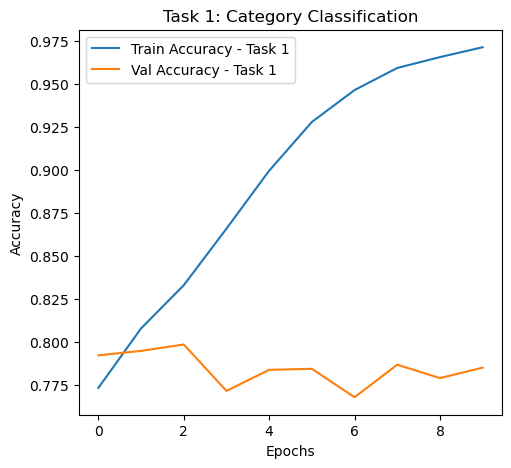

In [17]:
# Plot Training and Validation Accuracy for Task 1
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies_task1, label='Train Accuracy - Task 1')
plt.plot(val_accuracies_task1, label='Val Accuracy - Task 1')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Task 1: Category Classification')
plt.legend()

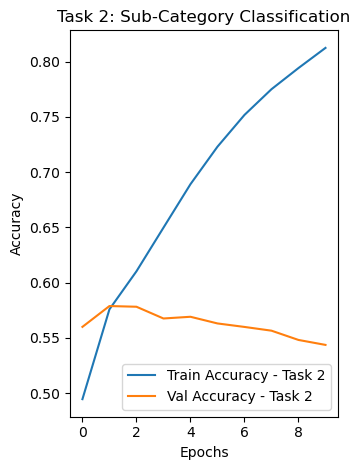

In [18]:
# Plot Training and Validation Accuracy for Task 2
plt.subplot(1, 2, 2)
plt.plot(train_accuracies_task2, label='Train Accuracy - Task 2')
plt.plot(val_accuracies_task2, label='Val Accuracy - Task 2')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Task 2: Sub-Category Classification')
plt.legend()

plt.tight_layout()
plt.show()


In [19]:
model_save_path = "model_state.pth"

# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)

In [20]:
# Specify path to save the checkpoint
checkpoint_path = "model_checkpoint.pth"

# Save model state, optimizer state, and any other necessary information
torch.save({
    # 'epoch': 10,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    # 'loss': loss,
}, checkpoint_path)
